In [2]:
import pandas as pd
from pathlib import Path
import numpy as np 
import sys
sys.path.insert(0, "..")   
from src.cluster_util import cluster_data
from src.BinaryTriFactorizationEstimator import BinaryTriFactorizationEstimator
from src.BTNMF_util import  get_normalized_assignments, explain_coverage, sweep_btf_grid, sweep_btf_grid, cluster_data_and_explain_blocks
from src.BTNMF_util import merge_blocks_by_stat, get_sorted_row_col, normalize_data_and_fit_estimator, pick_best_btf_setting
from src.data_utils import generate_growth_rate_features, normalize_data, collapse_block_id_by_store_item, get_nan_stats, median_mean_transform
from src.plot_util import plot_block_annot_heatmap


In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
%pwd

'/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook'

In [4]:
df = pd.read_parquet("../output/data/train_2014_January_12_store_20_item_cluster.parquet")
cols = [
        "date",
        "store_item",
        "store",
        "item",
        "store_cluster",
        "item_cluster",
        "weight",
        "onpromotion",
        "unit_sales"
    ]
df = df[cols]
df['store_item'] = df['store_item'].astype(str)
df.sort_values(["date", "store_item"], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,date,store_item,store,item,store_cluster,item_cluster,weight,onpromotion,unit_sales
0,2014-01-01,1_1047679,1,1047679,8,1,1,False,0.0
1,2014-01-01,1_1168718,1,1168718,8,0,1,False,0.0
2,2014-01-01,1_1463591,1,1463591,8,0,1,False,0.0
3,2014-01-01,1_1463992,1,1463992,8,4,1,False,0.0
4,2014-01-01,1_1464092,1,1464092,8,5,1,False,0.0


In [12]:
data_path = Path("../output/data/growth_rate_2014_January_top_53_store_2000_item/growth_rate_2014_January_top_53_store_2000_item.parquet")
#data_path = Path("../output/data/growth_rate_2014_January_12_store_20_item.parquet")
df = pd.read_parquet(data_path)

In [13]:
df.describe()

,start_date,store,item,weight,sales_day_1,onpromotion_day_1,growth_rate_1
count,2914000,2.914000e+06,2.914000e+06,2914000.0,2.914000e+06,2914000.0,1.400130e+06
mean,2014-01-16 00:00:00.000000256,2.651064e+01,9.564934e+05,1.0,5.511767e+00,0.0,2.578302e+01
min,2014-01-01 00:00:00,1.000000e+00,9.699500e+04,1.0,-1.700000e+02,0.0,-4.000000e+03
25%,2014-01-08 00:00:00,1.200000e+01,5.709208e+05,1.0,0.000000e+00,0.0,-6.000000e+01
50%,2014-01-16 00:00:00,2.700000e+01,1.005464e+06,1.0,0.000000e+00,0.0,-1.111111e+01
75%,2014-01-24 00:00:00,4.000000e+01,1.370548e+06,1.0,5.000000e+00,0.0,5.000000e+01
max,2014-01-31 00:00:00,5.400000e+01,1.909755e+06,1.0,1.000000e+04,0.0,5.330000e+04
std,NaN,1.562850e+01,4.603335e+05,0.0,1.811124e+01,0.0,2.056105e+02


In [14]:
data_path = Path("../output/data/growth_rate_2014_January_top_53_store_2000_item/growth_rate_2014_January_top_53_store_2000_item_cluster_bt.parquet")
df = pd.read_parquet(data_path)
df.describe()

,start_date,store,item,weight,sales_day_1,onpromotion_day_1,growth_rate_1,block_id
count,2914000,2.914000e+06,2.914000e+06,2914000.0,2.914000e+06,2914000.0,1.400130e+06,2914000.0
mean,2014-01-16 00:00:00.000000256,2.651064e+01,9.564934e+05,1.0,5.511767e+00,0.0,2.578302e+01,24.0
min,2014-01-01 00:00:00,1.000000e+00,9.699500e+04,1.0,-1.700000e+02,0.0,-4.000000e+03,24.0
25%,2014-01-08 00:00:00,1.200000e+01,5.709208e+05,1.0,0.000000e+00,0.0,-6.000000e+01,24.0
50%,2014-01-16 00:00:00,2.700000e+01,1.005464e+06,1.0,0.000000e+00,0.0,-1.111111e+01,24.0
75%,2014-01-24 00:00:00,4.000000e+01,1.370548e+06,1.0,5.000000e+00,0.0,5.000000e+01,24.0
max,2014-01-31 00:00:00,5.400000e+01,1.909755e+06,1.0,1.000000e+04,0.0,5.330000e+04,24.0
std,NaN,1.562850e+01,4.603335e+05,0.0,1.811124e+01,0.0,2.056105e+02,0.0


In [15]:
df["block_id"].unique()

array([24])

In [33]:
print(df["store"].nunique())
print(df["item"].nunique())

47
2000


In [21]:
df2 = df.query("store == 10 & item == 1003679")
df2.to_csv("../output/data/10_1003679_growth_rate.csv", index=False)


In [54]:
alpha=10
beta=0.1
block_l1=0.5
b_inner=30
max_iter=200  
tol=10
make_btf = BinaryTriFactorizationEstimator.factory(
    k_row=None,
    k_col=None,
    loss="gaussian",
    alpha=alpha,
    beta=beta,
    block_l1=block_l1,  # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=b_inner,  # inner prox steps for B when block_l1>0
    max_iter=max_iter,
    tol=tol,
    verbose=True,
)

# # Define your grid
# norm_data = normalize_data(
#     df,
#     column_name="growth_rate_1",
#     log_transform=False,
#     median_transform=False,
#     mean_transform=True,
#     zscore_rows=False,
#     zscore_cols=True,
# )

In [50]:
norm_data

item,96995,103501,103520,103665,105574,105575,105576,105577,105693,105857,...,1751175,1751176,1903391,1903428,1903432,1906100,1909453,1909724,1909754,1909755
store,,,,,,,,,,,,,,,,,,,,,
1,-1.577420e-02,7.314708e-08,0.425852,-1.176060e+00,3.743593e+00,4.400491e-01,4.853174e-09,-5.403745e-01,-2.861440e+00,6.410341e-08,...,1.076992e+00,2.675883e+00,2.955193e-01,-5.670862e-01,-3.719980e-08,1.244920e+00,7.937642e-08,-1.500547e+00,-1.323564e-08,6.182832e-01
2,8.461392e-02,7.314708e-08,-0.396411,5.393975e-01,6.488598e-02,-1.338929e+00,4.853174e-09,8.655858e-01,-1.264408e+00,6.410341e-08,...,5.079273e-01,-3.695862e-01,-1.702676e-01,5.002892e-01,-1.363101e-01,3.230568e-01,2.344939e+00,2.925635e-01,2.167114e+00,1.355341e+00
3,-4.507890e-01,7.314708e-08,0.983285,-4.975978e-01,-4.303595e-01,-7.682155e-01,4.853174e-09,1.254288e-01,3.344385e-01,6.410341e-08,...,1.769323e-02,-6.586525e-01,1.360780e+00,7.792622e-01,1.058335e+00,1.320369e+00,1.920135e+00,1.575916e+00,1.575854e+00,-1.482281e+00
4,7.744339e-02,7.314708e-08,-0.646360,1.198114e+00,-6.425768e-01,3.826009e+00,4.853174e-09,6.836196e-01,8.055205e-01,6.410341e-08,...,3.149152e-01,-4.147634e-01,3.695227e-01,-9.552229e-01,-3.719980e-08,-1.157718e-08,5.210144e-01,-8.850520e-01,-1.399518e+00,-3.077121e-08
5,-1.054483e+00,7.314708e-08,0.022844,-9.754083e-01,-8.165717e-01,-2.628150e-01,4.853174e-09,2.290626e+00,1.150295e+00,6.410341e-08,...,2.430091e-01,-1.469401e-01,9.708011e-01,-1.585945e+00,-1.583668e+00,-1.157718e-08,1.038587e+00,-7.238510e-01,-1.323564e-08,-3.077121e-08
6,-4.152778e-01,7.314708e-08,0.304146,2.117090e+00,2.277630e+00,2.058724e-01,4.853174e-09,9.324760e-01,-1.137678e+00,6.410341e-08,...,3.434486e-01,-3.082866e-01,-6.110237e-01,-3.245009e-01,-3.719980e-08,-1.157718e-08,6.209058e-01,1.691720e-08,4.124076e-01,-3.077121e-08
7,-1.693689e+00,7.314708e-08,-0.449826,1.072113e+00,-7.986810e-01,-5.001207e-01,4.853174e-09,1.079831e+00,-1.273294e+00,6.410341e-08,...,-9.083735e-04,-4.556096e-01,1.536051e+00,-1.585945e+00,-3.719980e-08,7.225219e-01,5.831231e-01,-1.078493e+00,-1.323564e-08,-3.077121e-08
8,-1.395393e+00,7.314708e-08,1.214750,1.175071e+00,-1.335829e+00,-8.417438e-01,4.853174e-09,1.645273e+00,4.271707e-02,2.618996e-01,...,3.536324e-01,4.489043e-01,9.708011e-01,2.282483e+00,3.240859e+00,-7.268920e-01,-2.739764e-01,1.486518e+00,-8.273308e-01,1.303568e-01
9,-5.492830e-08,3.450984e-01,-0.490530,-1.019591e+00,-3.474111e-08,-8.370075e-08,-9.841843e-01,-4.155900e-09,-6.550164e-02,6.410341e-08,...,-7.798483e-01,3.622576e+00,2.215157e-01,1.173463e+00,2.275954e+00,-1.157718e-08,8.743437e-01,1.691720e-08,-1.256471e+00,-3.077121e-08


In [55]:
min_keep = 0
n_jobs = 1
batch_size = 4
# Run the sweep
R_list = range(500, 501)
C_list = range(500, 501)
max_iter=200  
tol=10
grid_df = sweep_btf_grid(
    make_btf,
    norm_data.to_numpy(dtype=np.float32),
    R_list,
    C_list,
    restarts=3,
    seeds=range(123, 999),  # optional
    min_keep=min_keep,
    fit_kwargs={"max_iter": max_iter, "tol": tol},
    n_jobs=n_jobs,
    batch_size=batch_size,
)

2025-09-18 08:54:53,199 - INFO - Total (R,C) combinations to process: 1
2025-09-18 08:54:53,200 - INFO - Using 1 processes for BTF grid search
2025-09-18 08:54:53,201 - INFO - Fitting BTF with R=500, C=500
2025-09-18 08:54:55,358 - INFO - [iter 00] loss=4.480754e+04  rss=8.035469e+04
2025-09-18 08:54:57,268 - INFO - [iter 00] loss=4.507930e+04  rss=8.149880e+04
2025-09-18 08:54:59,962 - INFO - [iter 00] loss=4.487383e+04  rss=8.057685e+04


KeyboardInterrupt: 

In [ ]:
# Rank and pick the best
ranked_df, best = pick_best_btf_setting(
    grid_df, max_pve_drop=max_pve_drop, min_sil=min_sil
)


In [ ]:

TOP_RANK_FN="../output/data/growth_rate_2014_January_top_53_store_2000_item_cluster_bt_top_rank.csv"
SUMMARY_FN="../output/data/growth_rate_2014_January_top_53_store_2000_item_cluster_bt_summary.csv"
FIGURE_FN="../output/data/growth_rate_2014_January_top_53_store_2000_item_cluster_bt_figure.tiff"
OUTPUT_FN="../output/data/growth_rate_2014_January_top_53_store_2000_item_cluster_bt.parquet"
cluster_data_and_explain_blocks(
            df,
            row_range=range(2, 5),
            col_range=range(2, 5),
            alpha=ALPHA,
            beta=BETA,
            block_l1=BLOCK_L1,
            b_inner=B_INNER,
            max_iter=MAX_ITER,
            tol=TOL,
            max_pve_drop=MAX_PVE_DROP,
            min_sil=MIN_SIL,
            min_keep=MIN_KEEP,
            top_k=TOP_K,
            top_rank_fn=TOP_RANK_FN,
            summary_fn=SUMMARY_FN,
            output_fn=OUTPUT_FN,
            figure_fn=FIGURE_FN,
            n_jobs=1,
            batch_size=4,
)

In [71]:
df = pd.read_csv("../output/data/growth_rate_features.csv")
df.head()

,start_date,store_item,store,item,weight,sales_day_1,growth_rate_1,onpromotion_day_1
0,2014-01-01,1_401911,1,401911,1,0.0,NaN,0
1,2014-01-01,1_557286,1,557286,1,0.0,NaN,0
2,2014-01-01,1_567781,1,567781,1,0.0,NaN,0
3,2014-01-01,1_587069,1,587069,1,0.0,NaN,0
4,2014-01-01,1_671076,1,671076,1,0.0,NaN,0


In [5]:
est_maker = BinaryTriFactorizationEstimator.factory(
    k_row=None, 
    k_col=None, 
    loss="gaussian", 
    alpha=1e-2, 
    beta=0.6,
     block_l1=0.1,             # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=15,               # inner prox steps for B when block_l1>0
    max_iter=50,
    tol=1e-5,
)
n_row = 5
n_col = 5   
est, assign = normalize_data_and_fit_estimator(df, est_maker, n_row, n_col, random_state=0, min_keep=-10)

In [7]:
norm_data

item,96995,103501,103520,103665,105574,105575,105576,105577,105693,105857,...,1751175,1751176,1903391,1903428,1903432,1906100,1909453,1909724,1909754,1909755
store,,,,,,,,,,,,,,,,,,,,,
1,-62.500000,0.000000,25.462961,6.597985,75.561226,25.486479,0.000000,2.777778,-82.142860,0.000000,...,43.423183,90.912186,-47.777775,-73.076920,0.000000,30.350531,0.000000,-63.636364,0.000000,-28.555553
2,-60.256409,0.000000,-7.941176,46.819729,29.366516,5.540502,0.000000,30.235857,-32.222221,0.000000,...,25.013975,2.062717,-61.764706,-44.871792,-70.000000,9.649123,16.089745,-5.701755,3.888889,-8.750000
3,-72.222221,0.000000,48.108467,22.505655,23.147560,11.939368,0.000000,15.780763,17.755102,0.000000,...,9.154934,-6.370593,-15.789474,-37.500000,-45.238094,32.044819,2.936507,35.762787,-13.333333,-85.000000
4,-60.416664,0.000000,-18.095238,62.264427,20.482679,63.449993,0.000000,26.682100,32.480358,0.000000,...,18.770044,0.744704,-45.555553,-83.333336,0.000000,0.000000,-40.384617,-43.750000,-100.000000,0.000000
5,-85.714287,0.000000,9.090910,11.302597,18.297770,17.605938,0.000000,58.066574,43.257450,0.000000,...,16.443890,8.558266,-27.500000,-100.000000,-100.000000,0.000000,-24.358976,-38.541664,0.000000,0.000000
6,-71.428574,0.000000,20.518707,83.811333,57.152649,22.860880,0.000000,31.542208,-28.260870,0.000000,...,19.693098,3.851093,-75.000000,-66.666664,0.000000,0.000000,-37.291668,0.000000,-47.222225,0.000000
7,-100.000000,0.000000,-10.111112,59.310135,18.522429,14.945257,0.000000,34.420025,-32.500000,0.000000,...,8.553173,-0.446957,-10.526316,-100.000000,0.000000,18.619528,-38.461540,-50.000000,0.000000,0.000000
8,-93.333336,0.000000,57.511620,61.724136,11.777293,11.114965,0.000000,45.462963,8.636364,-58.571430,...,20.022545,25.941616,-27.500000,2.222223,0.000000,-13.928571,-65.000000,32.874393,-83.333336,-41.666668
9,0.000000,27.141354,-11.764706,10.266667,0.000000,0.000000,16.256083,0.000000,5.253623,0.000000,...,-16.645483,118.531319,-50.000000,-27.083334,-20.000000,0.000000,-29.444445,0.000000,-95.833336,0.000000


In [15]:
#row_order, col_order = est.get_row_col_orders(assign, norm_data2)
df2 = get_normalized_assignments(assign, norm_data)  # contains unique per-cell block_id
row_order, col_order = get_sorted_row_col(df2)

fn = Path("../output/figures/store_item_Jan_2014_heatmap.tiff")
# plot (no dates in this table)
plot_block_annot_heatmap(
    df2,
    ttl="Store-Item Clusters",
    value_col="growth_rate_1", 
    block_col="block_id",
    row_col="store", 
    col_col="item",
    date_col=None,                
    row_order=row_order, 
    col_order=col_order,
    fmt= "{:.0f}",
    cell_h=0.6, 
    cell_w=0.75, 
    font_size=11,
    #figsize=(6, 4),
    xlabel_size=14,
    ylabel_size=14,
    label_weight="bold",
    fn=None,
    xtick_rotation=45,
)

KeyboardInterrupt: 

In [99]:
# norm_data = normalize_data(
#     df,
#     column_name="growth_rate_1",
#     log_transform=False,
#     median_transform=True,
#     mean_transform=False,
#     zscore_rows=False,
#     zscore_cols=False,   # <-- truly off now
# )
# X = norm_data.fillna(0.0).to_numpy(np.float32)
mat = df.pivot_table(values="growth_rate_1", index="store", columns="item", aggfunc="median")
cnt = df.pivot_table(values="growth_rate_1", index="store", columns="item", aggfunc="count")
mat = mat.sort_index().sort_index(axis=1)
cnt = cnt.reindex(index=mat.index, columns=mat.columns)

col_means_obs = mat.where(cnt > 0).mean(axis=0)
mat_imp = mat.copy()
for c in mat.columns:
    v = mat[c].to_numpy(copy=True)
    miss = (cnt[c].to_numpy() == 0)
    v[miss] = col_means_obs[c]
    mat_imp[c] = v

# column mean-center (matches PVE baseline="column_mean")
Xc = (mat_imp - mat_imp.mean(axis=0)).to_numpy(np.float32)

make_btf = BinaryTriFactorizationEstimator.factory(
    n_row_clusters=10,         # try a few values (e.g., 3–8)
    n_col_clusters=10,
    k_row=2, 
    k_col=2,
    loss="gaussian",
    alpha=10,          # moderate ridge on raw scale
    beta=10,
    block_l1=0.01,
    b_inner=50,
    max_iter=100,
    tol=1e-6,
    verbose=True,
)
est = make_btf(n_row_clusters=6, n_col_clusters=6, random_state=123)
est.history_flag = True
est.fit(Xc)
print("iters:", len(est.loss_history_))
print("PVE (column_mean):", est.compute_tss_rss_pve(Xc, baseline="column_mean")["pve"])


2025-09-16 15:17:32,462 - INFO - [iter 00] loss=2.758682e+07  rss=5.510678e+07
2025-09-16 15:17:32,622 - INFO - [iter 01] loss=2.550320e+07  rss=5.093413e+07
2025-09-16 15:17:32,781 - INFO - [iter 02] loss=2.476439e+07  rss=4.946141e+07
2025-09-16 15:17:32,940 - INFO - [iter 03] loss=2.453955e+07  rss=4.901311e+07
2025-09-16 15:17:33,088 - INFO - [iter 04] loss=2.428954e+07  rss=4.851418e+07
2025-09-16 15:17:33,235 - INFO - [iter 05] loss=2.414701e+07  rss=4.822988e+07
2025-09-16 15:17:33,355 - INFO - [iter 06] loss=2.414490e+07  rss=4.822590e+07
2025-09-16 15:17:33,472 - INFO - [iter 07] loss=2.395032e+07  rss=4.783730e+07
2025-09-16 15:17:33,595 - INFO - [iter 08] loss=2.394203e+07  rss=4.782063e+07
2025-09-16 15:17:33,719 - INFO - [iter 09] loss=2.391532e+07  rss=4.776752e+07
2025-09-16 15:17:33,838 - INFO - [iter 10] loss=2.390503e+07  rss=4.774711e+07
2025-09-16 15:17:33,959 - INFO - [iter 11] loss=2.387543e+07  rss=4.768819e+07
2025-09-16 15:17:34,081 - INFO - [iter 12] loss=2.38

iters: 13
PVE (column_mean): 18.337733207541884


In [108]:
import numpy as np

def suggest_min_keep_elbow(est) -> int:
    if est.U_ is None or est.V_ is None or est.B_ is None:
        raise ValueError("Fit the model first.")
    U, V, B = est.U_, est.V_, est.B_
    nr = U.sum(axis=0).astype(float)              # (R,)
    nc = V.sum(axis=0).astype(float)              # (C,)
    R, C = B.shape

    # block "energy"
    E = (B**2) * (nr[:, None] * nc[None, :])     # (R,C)
    e = np.sort(E.ravel())[::-1]                  # descending
    m = e.size
    if m == 0 or np.all(e == 0):
        return 1

    frac = np.cumsum(e) / (e.sum() + 1e-12)       # cumulative explained share
    x = (np.arange(1, m + 1) / m)                 # normalized k
    # Knee as max vertical distance above the diagonal
    k_star = int(np.argmax(frac - x)) + 1         # convert to 1-based count
    return max(1, k_star)


In [11]:
# # # Run the sweep
mat = df.pivot_table(values="growth_rate_1", index="store", columns="item", aggfunc="median")
cnt = df.pivot_table(values="growth_rate_1", index="store", columns="item", aggfunc="count")
mat = mat.sort_index().sort_index(axis=1)
cnt = cnt.reindex(index=mat.index, columns=mat.columns)

col_means_obs = mat.where(cnt > 0).mean(axis=0)
mat_imp = mat.copy()
for c in mat.columns:
    v = mat[c].to_numpy(copy=True)
    miss = (cnt[c].to_numpy() == 0)
    v[miss] = col_means_obs[c]
    mat_imp[c] = v

# column mean-center (matches PVE baseline="column_mean")
Xc = (mat_imp - mat_imp.mean(axis=0)).to_numpy(np.float32)
R_list = range(500, 501)
C_list = range(500, 501)

make_btf = BinaryTriFactorizationEstimator.factory(
    k_row=1, k_col=1,     # simplest, stable first pass
    loss="gaussian",
    alpha=10.0,            # try 3.0; if shaky: 10.0. If too stiff: 1.0
    beta=0.01,
    block_l1=0.5,
    b_inner=30,
    max_iter=20,         # give it runway (200–1000)
    tol=0.0,              # we already patched early-stop; 0 disables it
    verbose=False,
)

grid_df = sweep_btf_grid(
    make_btf,
    Xc,
    R_list,
    C_list,
    restarts=3,
    seeds=range(123, 999),     # optional
    min_keep=2,
    fit_kwargs={"max_iter": 200, "tol": 1e-4},  # pass your estimator kwargs here
    n_jobs=1,
    batch_size=4,
)

2025-09-18 07:54:55,088 - INFO - Total (R,C) combinations to process: 1
2025-09-18 07:54:55,089 - INFO - Using 1 processes for BTF grid search
2025-09-18 07:54:55,089 - INFO - Fitting BTF with R=500, C=500
2025-09-18 07:55:27,009 - INFO - Computing cell mask for R=500, C=500


In [12]:
ranked_df, best = pick_best_btf_setting(grid_df, max_pve_drop=0.1, min_sil=-2)
ranked_df

,n_row,n_col,Mask_Nobs,Mask_Coverage,seed,Loss,Percent_Loss,RMSE,Percent_RMSE,PVE,Mean Silhouette,BlockContribution_Total,BlockContribution_PerCell,BlockContribution_RelBaseline,BlockContribution_FracWeak20,BlockContribution_Gini,B_Sparsity,Coverage,AIC,BIC
0,500,500,71,0.000756,123,3.905911e+07,66.885641,20.399672,81.783643,0.391007,0.536569,724308.752882,10201.531731,0.391387,0.0,0.999993,0.998,1.0,2.754025e+06,3.319695e+06


In [8]:
# --- count-aware impute (you already have this) ---
mat = df.pivot_table(values="growth_rate_1", index="store", columns="item", aggfunc="median")
cnt = df.pivot_table(values="growth_rate_1", index="store", columns="item", aggfunc="count")
mat = mat.sort_index().sort_index(axis=1)
cnt = cnt.reindex(index=mat.index, columns=mat.columns)

col_means_obs = mat.where(cnt > 0).mean(axis=0)
mat_imp = mat.copy()
for c in mat.columns:
    v = mat[c].to_numpy(copy=True)
    miss = (cnt[c].to_numpy() == 0)
    v[miss] = col_means_obs[c]
    mat_imp[c] = v

# column mean-center (matches PVE baseline="column_mean")
Xc = (mat_imp - mat_imp.mean(axis=0)).to_numpy(np.float32)

# --- stable warm-start config ---
make_btf = BinaryTriFactorizationEstimator.factory(
    k_row=1, k_col=1,     # simplest, stable first pass
    loss="gaussian",
    alpha=10.0,            # try 3.0; if shaky: 10.0. If too stiff: 1.0
    beta=0.01,
    block_l1=0.5,
    b_inner=30,
    max_iter=20,         # give it runway (200–1000)
    tol=0.0,              # we already patched early-stop; 0 disables it
    verbose=True,
)

# a few restarts; keep best PVE
best = None
for seed in (123, 321, 777, 999):
    est = make_btf(n_row_clusters=6, 
                   n_col_clusters=6, 
                   random_state=seed)
    est.history_flag = True
    est.fit(Xc)
    pve = est.compute_tss_rss_pve(Xc, baseline="column_mean")["pve"]
    if (best is None) or (pve > best[0]):
        best = (pve, seed, est)

print(f"Warm PVE: {best[0]:.2f}% @ seed {best[1]}")

# --- second pass: a bit more expressive ---
est2 = make_btf(n_row_clusters=8, n_col_clusters=8,
                random_state=best[1], 
                k_row=2, 
                k_col=2, 
                alpha=3.0)
est2.fit(Xc)
pve2 = est2.compute_tss_rss_pve(Xc, baseline="column_mean")["pve"]
print(f"R=8,C=8,k=2 PVE: {pve2:.2f}%")

# (optional) light structure after it moves
est3 = make_btf(n_row_clusters=200, 
                n_col_clusters=200,
                random_state=best[1], 
                k_row=2, 
                k_col=2, 
                alpha=3.0
    )
est3.fit(Xc)
pve3 = est3.compute_tss_rss_pve(Xc, baseline="column_mean")["pve"]
print(f"+beta=0.1 PVE: {pve3:.2f}%")


2025-09-18 07:52:21,105 - INFO - [iter 00] loss=2.804848e+07  rss=5.609691e+07
2025-09-18 07:52:21,196 - INFO - [iter 01] loss=2.598072e+07  rss=5.196140e+07
2025-09-18 07:52:21,291 - INFO - [iter 02] loss=2.553685e+07  rss=5.107365e+07
2025-09-18 07:52:21,379 - INFO - [iter 03] loss=2.537692e+07  rss=5.075380e+07
2025-09-18 07:52:21,538 - INFO - [iter 04] loss=2.527455e+07  rss=5.054906e+07
2025-09-18 07:52:21,630 - INFO - [iter 05] loss=2.516817e+07  rss=5.033631e+07
2025-09-18 07:52:21,728 - INFO - [iter 06] loss=2.511678e+07  rss=5.023351e+07
2025-09-18 07:52:21,831 - INFO - [iter 07] loss=2.508849e+07  rss=5.017694e+07
2025-09-18 07:52:21,925 - INFO - [iter 08] loss=2.507621e+07  rss=5.015238e+07
2025-09-18 07:52:22,019 - INFO - [iter 09] loss=2.504072e+07  rss=5.008141e+07
2025-09-18 07:52:22,106 - INFO - [iter 10] loss=2.494708e+07  rss=4.989412e+07
2025-09-18 07:52:22,189 - INFO - [iter 11] loss=2.486591e+07  rss=4.973178e+07
2025-09-18 07:52:22,276 - INFO - [iter 12] loss=2.48

Warm PVE: 16.01% @ seed 321


2025-09-18 07:52:28,178 - INFO - [iter 01] loss=2.459393e+07  rss=4.918780e+07
2025-09-18 07:52:28,296 - INFO - [iter 02] loss=2.406130e+07  rss=4.812253e+07
2025-09-18 07:52:28,412 - INFO - [iter 03] loss=2.380753e+07  rss=4.761499e+07
2025-09-18 07:52:28,523 - INFO - [iter 04] loss=2.362534e+07  rss=4.725061e+07
2025-09-18 07:52:28,640 - INFO - [iter 05] loss=2.345506e+07  rss=4.691005e+07
2025-09-18 07:52:28,752 - INFO - [iter 06] loss=2.338106e+07  rss=4.676205e+07
2025-09-18 07:52:28,863 - INFO - [iter 07] loss=2.332974e+07  rss=4.665942e+07
2025-09-18 07:52:28,976 - INFO - [iter 08] loss=2.328473e+07  rss=4.656940e+07
2025-09-18 07:52:29,093 - INFO - [iter 09] loss=2.324189e+07  rss=4.648371e+07
2025-09-18 07:52:29,225 - INFO - [iter 10] loss=2.317949e+07  rss=4.635892e+07
2025-09-18 07:52:29,355 - INFO - [iter 11] loss=2.313863e+07  rss=4.627720e+07
2025-09-18 07:52:29,487 - INFO - [iter 12] loss=2.311271e+07  rss=4.622535e+07
2025-09-18 07:52:29,613 - INFO - [iter 13] loss=2.30

R=8,C=8,k=2 PVE: 21.43%


2025-09-18 07:52:30,900 - INFO - [iter 00] loss=2.054538e+07  rss=4.109068e+07
2025-09-18 07:52:31,304 - INFO - [iter 01] loss=1.625351e+07  rss=3.250694e+07
2025-09-18 07:52:31,771 - INFO - [iter 02] loss=1.529200e+07  rss=3.058392e+07
2025-09-18 07:52:32,140 - INFO - [iter 03] loss=1.484755e+07  rss=2.969502e+07
2025-09-18 07:52:32,522 - INFO - [iter 04] loss=1.474985e+07  rss=2.949962e+07
2025-09-18 07:52:32,899 - INFO - [iter 05] loss=1.470271e+07  rss=2.940533e+07
2025-09-18 07:52:33,264 - INFO - [iter 06] loss=1.456127e+07  rss=2.912247e+07
2025-09-18 07:52:33,649 - INFO - [iter 07] loss=1.451254e+07  rss=2.902501e+07
2025-09-18 07:52:34,066 - INFO - [iter 08] loss=1.451254e+07  rss=2.902501e+07
2025-09-18 07:52:34,434 - INFO - [iter 09] loss=1.451254e+07  rss=2.902501e+07
2025-09-18 07:52:34,796 - INFO - [iter 10] loss=1.451254e+07  rss=2.902501e+07
2025-09-18 07:52:35,183 - INFO - [iter 11] loss=1.451254e+07  rss=2.902501e+07
2025-09-18 07:52:35,542 - INFO - [iter 12] loss=1.45

+beta=0.1 PVE: 50.30%


In [26]:
# Freeze your defaults once, then sweep:
make_btf = BinaryTriFactorizationEstimator.factory(
    k_row=None, 
    k_col=None, 
    loss="gaussian", 
    alpha=1e-2, 
    beta=0.6,
    block_l1=0,             # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=15,               # inner prox steps for B when block_l1>0
    max_iter=50,
    tol=1e-5,
)
    
# Define your grid
R_list = range(2, 4)
C_list = range(2, 4)
norm_data = normalize_data(
        df,
        column_name="growth_rate_1", 
        log_transform=False, 
        median_transform=True, 
        mean_transform=False,
        zscore_rows=False,
        zscore_cols=True,
).fillna(0)
X = norm_data.to_numpy(dtype=np.float32)  # DO NOT fillna(0)
print("finite?", np.isfinite(X).all())
print("NaN frac:", np.isnan(X).mean())
print("Zero frac:", np.mean(np.nan_to_num(X)==0))  # should NOT be ~1.0
print("Var after normalization:", np.nanvar(X))

# # # Run the sweep
# grid_df = sweep_btf_grid(
#     make_btf,
#     norm_data.to_numpy(dtype=np.float32),
#     R_list,
#     C_list,
#     restarts=3,
#     seeds=range(123, 999),     # optional
#     min_keep=-20,
#     fit_kwargs={"max_iter": 200, "tol": 1e-4},  # pass your estimator kwargs here
#     n_jobs=1,
#     batch_size=4,
# )



finite? True
NaN frac: 0.0
Zero frac: 0.30025531914893616
Var after normalization: 0.6997447


In [9]:

# Rank and pick the best (edit ranking logic inside pick_best_btf_setting if desired)
ranked_df, best = pick_best_btf_setting(grid_df, max_pve_drop=0.1, min_sil=-2)


In [10]:
ranked_df

,n_row,n_col,Mask_Nobs,Mask_Coverage,seed,Loss,Percent_Loss,RMSE,Percent_RMSE,PVE,Mean Silhouette,BlockContribution_Total,BlockContribution_PerCell,BlockContribution_RelBaseline,BlockContribution_FracWeak20,BlockContribution_Gini,B_Sparsity,Coverage,AIC,BIC
0,4,4,94000,1.0,125,64198.017914,97.378907,0.826413,98.680752,2.621093e-02,-0.345005,1727.982083,1.838279e-02,2.621093e-02,0.0,0.933138,0.750000,1.0,128428.035828,128579.252629
1,4,3,94000,1.0,123,65925.999928,100.000000,0.837461,100.000000,1.049691e-09,-0.988759,0.000069,7.361910e-10,1.049691e-09,0.0,0.916667,0.666667,1.0,131875.999856,131989.412457
2,4,2,94000,1.0,124,65925.999928,100.000000,0.837461,100.000000,1.049691e-09,-0.988759,0.000069,7.361910e-10,1.049691e-09,0.0,0.875000,0.500000,1.0,131867.999856,131943.608257
3,2,2,94000,1.0,124,65925.999928,100.000000,0.837461,100.000000,1.049691e-09,-0.988759,0.000069,7.361910e-10,1.049691e-09,0.0,0.750000,0.500000,1.0,131859.999856,131897.804056
4,4,1,94000,1.0,123,65925.999944,100.000000,0.837461,100.000000,8.101854e-10,-0.931117,0.000053,5.682158e-10,8.101854e-10,0.0,0.750000,0.000000,1.0,131859.999888,131897.804088
5,2,4,94000,1.0,124,65925.999997,100.000000,0.837461,100.000000,0.000000e+00,-0.705677,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.750000,1.0,131867.999995,131943.608395
6,1,4,94000,1.0,123,65925.999997,100.000000,0.837461,100.000000,0.000000e+00,-1.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.750000,1.0,131859.999995,131897.804195
7,1,3,94000,1.0,123,65925.999997,100.000000,0.837461,100.000000,-2.220446e-16,-1.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.666667,1.0,131857.999995,131886.353145


In [1]:
ranked_df.to_csv("../output/data/btf_grid_df.csv", index=False)

NameError: name 'ranked_df' is not defined

In [29]:
best

n_row                                 4.000000
n_col                                 4.000000
Mask_Nobs                         94000.000000
Mask_Coverage                         1.000000
seed                                125.000000
Loss                              64198.017914
Percent_Loss                         97.378907
RMSE                                  0.826413
Percent_RMSE                         98.680752
PVE                                   0.026211
Mean Silhouette                      -0.345005
BlockContribution_Total            1727.982083
BlockContribution_PerCell             0.018383
BlockContribution_RelBaseline         0.026211
BlockContribution_FracWeak20          0.000000
BlockContribution_Gini                0.933138
B_Sparsity                            0.750000
Coverage                              1.000000
AIC                              128428.035828
BIC                              128579.252629
Name: 0, dtype: float64

In [120]:
est_maker = BinaryTriFactorizationEstimator.factory(
    n_row_clusters=best["n_row"],         # try a few values (e.g., 3–8)
    n_col_clusters=best["n_col"],
    k_row=None, 
    k_col=None,
    loss="gaussian", 
    alpha=1e-2, 
    beta=.6,
    block_l1=0.05,             # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=15,               # inner prox steps for B when block_l1>0
    max_iter=50,
    tol=1e-5,
)
n_row = best["n_row"]
n_col = best["n_col"]
est, assign = normalize_data_and_fit_estimator(df, est_maker, n_row, n_col, random_state=0, min_keep=6)


/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/data_utils.py:1457: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values, axis=axis, keepdims=True)
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


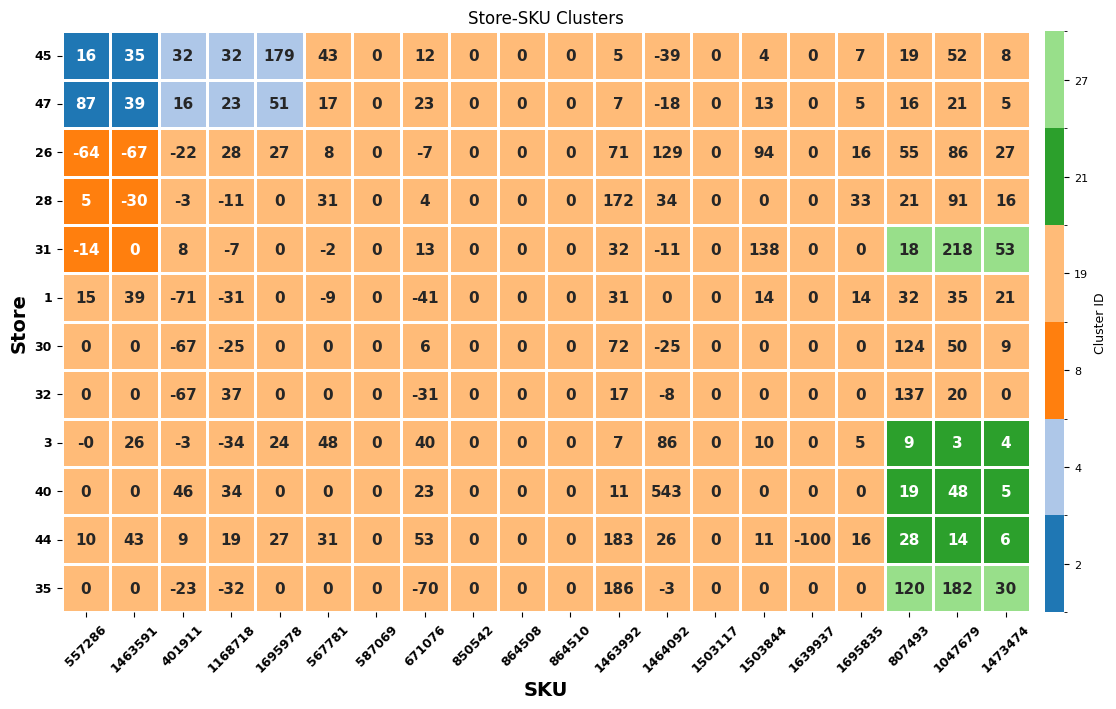

In [121]:
norm_data = normalize_data(
        df,
        column_name="growth_rate_1", 
        log_transform=False, 
        median_transform=False, 
        mean_transform=True,
        zscore_rows=False,
        zscore_cols=False,
).fillna(0)
df2 = get_normalized_assignments(assign, norm_data)  # contains unique per-cell block_id
row_order, col_order = get_sorted_row_col(df2)

fn = Path("../output/figures/store_item_Jan_2014_heatmap.tiff")
# plot (no dates in this table)
plot_block_annot_heatmap(
    df2,
    ttl="Store-SKU Clusters",
    value_col="growth_rate_1", 
    block_col="block_id",
    row_col="store", 
    col_col="item",
    date_col=None,                
    row_order=row_order, 
    col_order=col_order,
    fmt= "{:.0f}",
    cell_h=0.6, 
    cell_w=0.75, 
    font_size=11,
    #figsize=(6, 4),
    xlabel_size=14,
    ylabel_size=14,
    label_weight="bold",
    fn=None,
    xtick_rotation=45,
)

In [119]:
df = df.merge(df2.drop(columns="growth_rate_1", axis=1), on=["store", "item"], how="left")


In [120]:
df.head()

,start_date,store_item,store,item,weight,sales_day_1,growth_rate_1,onpromotion_day_1,block_id
0,2014-01-01,1_401911,1,401911,1,0.0,NaN,0,9
1,2014-01-01,1_557286,1,557286,1,0.0,NaN,0,1
2,2014-01-01,1_567781,1,567781,1,0.0,NaN,0,1
3,2014-01-01,1_587069,1,587069,1,0.0,NaN,0,1
4,2014-01-01,1_671076,1,671076,1,0.0,NaN,0,1


In [121]:
df.groupby("block_id").agg({"sales_day_1":"median"})

,sales_day_1
block_id,
0,148.420502
1,0.000000
6,2.000000
8,134.167503
9,0.000000
12,8.000000
14,1.000000


In [ ]:
df_long = df.groupby("block_id").agg({"sales_day_1": "median"}).rename(columns={"sales_day_1": "median_cluster_sales"}).reset_index()
df = df.merge(df_long, on="block_id", how="left")


In [119]:
df.head()

,start_date,store_item,store,item,weight,sales_day_1,growth_rate_1,onpromotion_day_1,block_id,median_cluster_sales
0,2014-01-01,1_401911,1,401911,1,0.0,NaN,0,8,0.0
1,2014-01-01,1_557286,1,557286,1,0.0,NaN,0,4,0.0
2,2014-01-01,1_567781,1,567781,1,0.0,NaN,0,9,0.0
3,2014-01-01,1_587069,1,587069,1,0.0,NaN,0,4,0.0
4,2014-01-01,1_671076,1,671076,1,0.0,NaN,0,9,0.0


In [110]:
# Convert matrix (store × item) into long form
from src.data_utils import mav

long_df = norm_data.stack().rename("value").reset_index()
long_df.columns = ["store", "item", "value"]
per_store_item = (
        long_df.groupby(["store", "item"])["value"]
        .apply(lambda g: mav(g, is_log1p=True, include_zeros=True))
        .reset_index(name="cluster_mav")
)
per_store_item

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


,store,item,cluster_mav
0,1,401911,3.806862e-01
1,1,557286,3.003211e+00
2,1,567781,1.994491e+00
3,1,587069,0.000000e+00
4,1,671076,1.033335e+00
...,...,...,...
235,47,1503117,0.000000e+00
236,47,1503844,1.072558e+171
237,47,1639937,0.000000e+00
238,47,1695835,6.876992e+85


In [58]:
summary = est.explain_blocks(
    X=norm_data.to_numpy(),
    assign=assign,               # <-- dict with block_id matrix
    row_names=norm_data.index.to_numpy(),
    col_names=norm_data.columns.to_numpy(),
    top_k=5,
)
summary


,block_id,r,c,B_rc,n_cells,coverage_%,mean,median,stores_in_r,items_in_c
1,46,4,2,1.242291,205,85.416667,13.110478,0.000000,"[3, 40]",[1464092]
3,84,7,7,1.241513,2,0.833333,122.114946,122.114946,"[30, 35]",[807493]
6,141,12,9,1.182589,10,4.166667,72.275591,61.835033,"[26, 31]","[401911, 671076, 1047679, 1463992, 1473474]"
8,172,15,7,1.003343,1,0.416667,136.649605,136.649605,[32],[807493]
4,89,8,1,0.908103,5,2.083333,36.260241,22.872224,[47],"[401911, 557286, 567781, 671076, 1463591]"
0,12,1,1,0.837414,5,2.083333,27.735673,31.640165,[45],"[401911, 557286, 567781, 671076, 1463591]"
7,142,12,10,-0.876256,2,0.833333,15.811181,15.811181,"[26, 31]","[1463992, 1695835]"
2,81,7,4,-0.889187,2,0.833333,-28.947368,-28.947368,"[30, 35]",[1168718]
5,133,12,1,-1.031827,8,3.333333,-20.856900,-10.664251,"[26, 31]","[401911, 557286, 567781, 671076, 1463591]"


In [38]:
summary.to_csv("../output/data/summary.csv", index=False)

In [39]:
explain_coverage(est, assign)

,c0,c1,c2,c3
r0,0,0,0,0
r1,10,0,186,0
r2,0,0,0,0
r3,20,0,12,0
r4,0,7,5,0


In [138]:
df2 = merge_blocks_by_stat(assign, df,norm_data2, est, stat="mean", scheme="kmeans", k=5)

In [139]:
df2.head()

,start_date,store_item,store,item,weight,sales_day_1,growth_rate_1,onpromotion_day_1,block_id
0,2014-01-01,1_401911,1,401911,1,0.0,NaN,0,0
1,2014-01-01,1_557286,1,557286,1,0.0,NaN,0,2
2,2014-01-01,1_567781,1,567781,1,0.0,NaN,0,1
3,2014-01-01,1_587069,1,587069,1,0.0,NaN,0,2
4,2014-01-01,1_671076,1,671076,1,0.0,NaN,0,1


In [140]:
df2.block_id.unique()

array([0, 2, 1, 4, 3])

In [141]:
df2 = collapse_block_id_by_store_item(df2, how="mean")   
row_order, col_order = get_sorted_row_col(df2)


2025-09-04 12:14:56,490 - INFO - Saving plot to ../output/figures/store_item_Jan_2014_mean_aggregated_heatmap.tiff


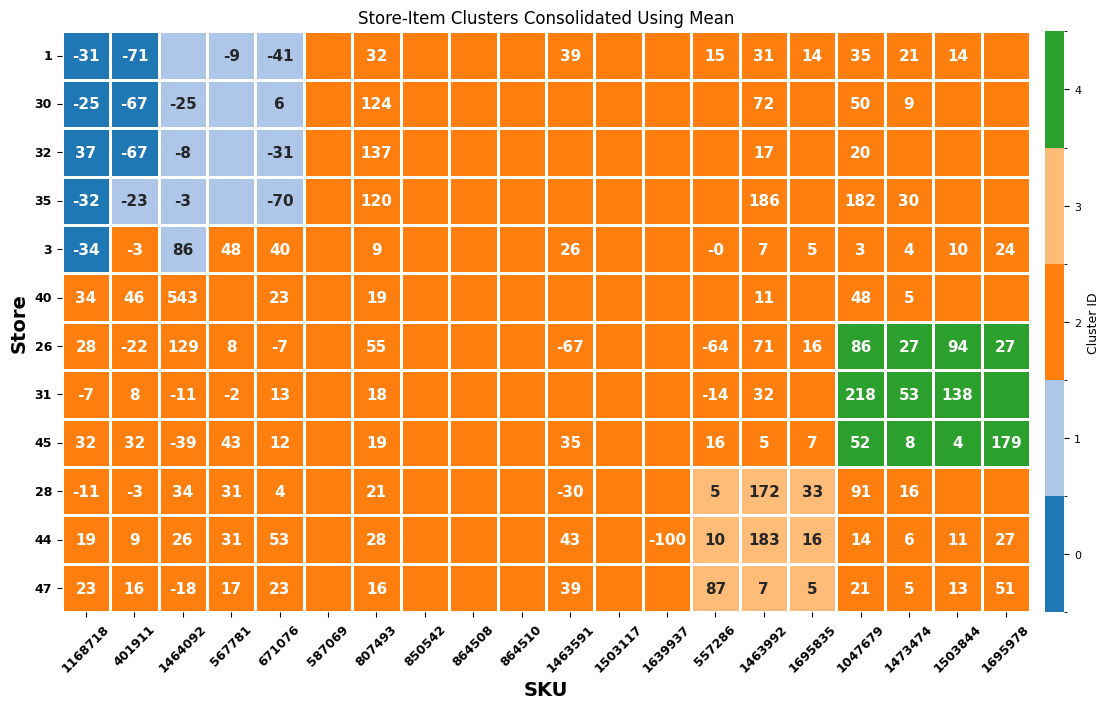

In [142]:
fn = Path("../output/figures/store_item_Jan_2014_mean_aggregated_heatmap.tiff")
plot_block_annot_heatmap(
    df2,
    ttl="Store-Item Clusters Consolidated Using Mean",
    value_col="growth_rate_1", 
    block_col="block_id",
    row_col="store", 
    col_col="item",
    date_col=None,                
    row_order=row_order, 
    col_order=col_order,
    fmt= "{:.0f}",
    cell_h=0.6, 
    cell_w=0.75, 
    font_size=11,
    #figsize=(6, 4),
    xlabel_size=14,
    ylabel_size=14,
    label_weight="bold",
    fn=fn,
    xtick_rotation=45,
)


In [143]:
# 1) make a (I×J) block-id matrix aligned to norm_data
bid_mat = (df2
           .pivot(index="store", columns="item", values="block_id")
           .reindex(index=norm_data.index, columns=norm_data.columns)
           .to_numpy())

# 2) pack it in a dict like assign_unique_blocks() returns
assign2 = {"block_id": bid_mat}

# 3) call your existing explain_blocks
summary = est.explain_blocks(
    X=norm_data2.to_numpy(),
    assign=assign2,               # <-- dict with block_id matrix
    row_names=norm_data.index.to_numpy(),
    col_names=norm_data.columns.to_numpy(),
    top_k=5,
)
summary


,block_id,r,c,B_rc,n_cells,coverage_%,mean,median,stores_in_r,items_in_c
4,4,0,4,1.216837,12,5.000000,73.737111,52.351386,"[3, 40]","[401911, 567781, 671076, 1464092]"
3,3,0,3,0.244778,9,3.750000,57.539447,15.917028,"[3, 40]","[401911, 1168718]"
1,1,0,1,-0.142181,14,5.833333,-8.400756,-5.729167,"[3, 40]","[587069, 807493, 850542, 864508, 864510]"
0,0,0,0,-0.392436,8,3.333333,-36.326004,-33.311404,"[3, 40]","[557286, 1463992, 1695835]"
2,2,0,2,-0.470107,197,82.083333,14.840881,0.000000,"[3, 40]","[1047679, 1473474, 1503844, 1695978]"


In [144]:
# assume you already have: est, X, assign from your current fit
df2 = merge_blocks_by_stat(assign, df,norm_data2, est, stat="median", scheme="kmeans", k=5)
df2.head()

,start_date,store_item,store,item,weight,sales_day_1,growth_rate_1,onpromotion_day_1,block_id
0,2014-01-01,1_401911,1,401911,1,0.0,NaN,0,0
1,2014-01-01,1_557286,1,557286,1,0.0,NaN,0,2
2,2014-01-01,1_567781,1,567781,1,0.0,NaN,0,1
3,2014-01-01,1_587069,1,587069,1,0.0,NaN,0,2
4,2014-01-01,1_671076,1,671076,1,0.0,NaN,0,1


In [145]:
df2.block_id.unique()

array([0, 2, 1, 4, 3])

In [146]:
df2 = collapse_block_id_by_store_item(df2, how="median")   
row_order, col_order = get_sorted_row_col(df2)


2025-09-04 12:15:01,118 - INFO - Saving plot to ../output/figures/store_item_Jan_2014_median_aggregated_heatmap.tiff


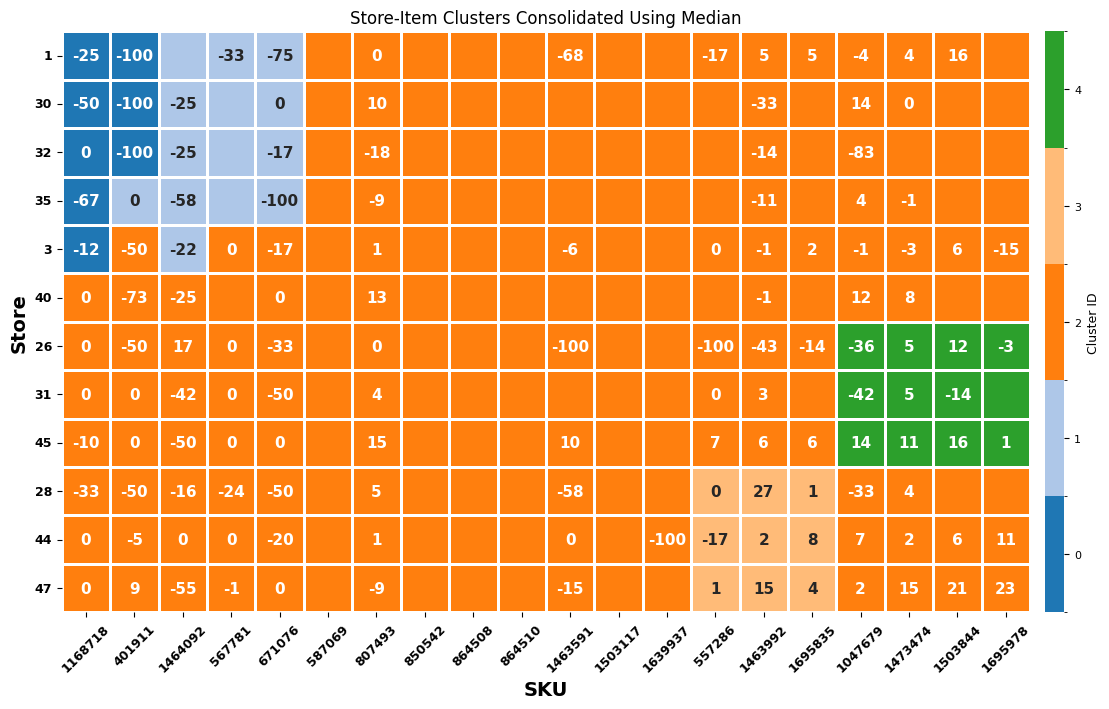

In [147]:
fn = Path("../output/figures/store_item_Jan_2014_median_aggregated_heatmap.tiff")
plot_block_annot_heatmap(
    df2,
    ttl="Store-Item Clusters Consolidated Using Median",
    value_col="growth_rate_1", 
    block_col="block_id",
    row_col="store", 
    col_col="item",
    date_col=None,                
    row_order=row_order, 
    col_order=col_order,
    fmt= "{:.0f}",
    cell_h=0.6, 
    cell_w=0.75, 
    font_size=11,
    #figsize=(6, 4),
    xlabel_size=14,
    ylabel_size=14,
    label_weight="bold",
    fn=fn,
    xtick_rotation=45,
)

In [6]:
data_path = Path("../output/data/growth_rate_2014_January_top_53_store_2000_item/growth_rate_2014_January_top_53_store_2000_item_cluster_bt.parquet")
df = pd.read_parquet(data_path)
df.head()

,start_date,store_item,store,item,weight,sales_day_1,onpromotion_day_1,growth_rate_1,block_id
0,2014-01-01,10_1003679,10,1003679,1.0,0.0,0,NaN,24
1,2014-01-02,10_1003679,10,1003679,1.0,4.0,0,NaN,24
2,2014-01-03,10_1003679,10,1003679,1.0,2.0,0,-50.0,24
3,2014-01-04,10_1003679,10,1003679,1.0,4.0,0,100.0,24
4,2014-01-05,10_1003679,10,1003679,1.0,1.0,0,-75.0,24


In [8]:
print(df['store'].nunique())
print(df['item'].nunique())

47
2000


In [9]:
df.describe()

,start_date,store,item,weight,sales_day_1,onpromotion_day_1,growth_rate_1,block_id
count,2914000,2.914000e+06,2.914000e+06,2914000.0,2.914000e+06,2914000.0,1.400130e+06,2914000.0
mean,2014-01-16 00:00:00.000000256,2.651064e+01,9.564934e+05,1.0,5.511767e+00,0.0,2.578302e+01,24.0
min,2014-01-01 00:00:00,1.000000e+00,9.699500e+04,1.0,-1.700000e+02,0.0,-4.000000e+03,24.0
25%,2014-01-08 00:00:00,1.200000e+01,5.709208e+05,1.0,0.000000e+00,0.0,-6.000000e+01,24.0
50%,2014-01-16 00:00:00,2.700000e+01,1.005464e+06,1.0,0.000000e+00,0.0,-1.111111e+01,24.0
75%,2014-01-24 00:00:00,4.000000e+01,1.370548e+06,1.0,5.000000e+00,0.0,5.000000e+01,24.0
max,2014-01-31 00:00:00,5.400000e+01,1.909755e+06,1.0,1.000000e+04,0.0,5.330000e+04,24.0
std,NaN,1.562850e+01,4.603335e+05,0.0,1.811124e+01,0.0,2.056105e+02,0.0


In [40]:
# Your data as a list of lists
data = [
    [39, 43, 4, 9, 14, 10, 14],
    [45, 58, 6, 12, 16, 7, 13],
    [1, 14, 3, 64, 21, 11, 15],
    [51, 49, 5, 11, 2, 0, 0],
    [0, 9, 2, 56, 0, 1, 2]
]

# Column names
columns = [1, 2, 3, 4, 5, 6, 7]

# Row labels
index = [1, 2, 3, 4, 5]

# Create DataFrame
df = pd.DataFrame(data, columns=columns, index=index)
# Set index name and dtype
df.index = df.index.astype("int64")  # ensure dtype
df.index.name = "store"              # set name

# Set columns dtype and name
df.columns = df.columns.astype("int64")  # ensure dtype
df.columns.name = "item"                 # set name
df

item,1,2,3,4,5,6,7
store,,,,,,,
1,39,43,4,9,14,10,14
2,45,58,6,12,16,7,13
3,1,14,3,64,21,11,15
4,51,49,5,11,2,0,0
5,0,9,2,56,0,1,2


In [41]:

# always coerce to float
X = df.to_numpy(dtype=np.float64)

est = BinaryTriFactorizationEstimator(
    n_row_clusters=9,         # try a few values (e.g., 3–8)
    n_col_clusters=4,
    k_row=None,               # no cap → multi-hard chosen by data
    k_col=None,
    loss="gaussian",
    alpha=1e-2,               # ridge on B for stability
    beta=0.4,                 # >0 makes memberships sparser
    block_l1=0.1,             # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=15,               # inner prox steps for B when block_l1>0
    max_iter=60,
    tol=1e-5,
    random_state=42,
    verbose=False,
).fit(X)



In [42]:
#assign = est.filter_blocks(X= df.to_numpy(), min_keep=10)
mask   = est.allowed_mask_from_gap(min_keep=5)   # aim for ~5 colors
assign = est.assign_unique_blocks(X= X, method="gaussian_delta",
                                  allowed_mask=mask, on_empty="fallback")
block_id = assign["block_id"]  # (I×J), each cell → one color
df2 = get_normalized_assignments(assign, df)

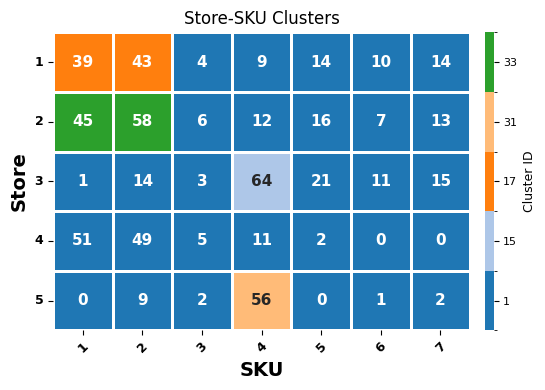

In [43]:
#row_order, col_order = est.get_row_col_orders(assign, df)
#row_order, col_order = est.get_row_col_orders(assign, norm_data2)
df2 = get_normalized_assignments(assign, df)  # contains unique per-cell block_id
#row_order, col_order = get_row_col_orders_smart(df2)
row_order = sorted(df2["store"].unique())
col_order = sorted(df2["item"].unique())

fn = Path("../output/figures/store_item_toy_data_heatmap.tiff")
plot_block_annot_heatmap(
    df2,
    ttl="Store-SKU Clusters",
    value_col="growth_rate_1", 
    block_col="block_id",
    row_col="store", 
    col_col="item",
    date_col=None,                
    row_order=row_order, 
    col_order=col_order,
    fmt= "{:.0f}",
    cell_h=0.6, 
    cell_w=0.75, 
    font_size=11,
    #figsize=(6, 4),
    x_label="SKU",
    y_label="Store",
    xlabel_size=14,
    ylabel_size=14,
    label_weight="bold",
    fn=None,
    xtick_rotation=45,
)

In [48]:
# Freeze your defaults once, then sweep:
make_btf = BinaryTriFactorizationEstimator.factory(
    k_row=None, 
    k_col=None, 
    loss="gaussian", 
    alpha=1e-2, 
    beta=0.6,
    block_l1=0.1,             # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=15,               # inner prox steps for B when block_l1>0
    max_iter=50,
    tol=1e-5,
)
    
# Define your grid
R_list = range(1, 10)
C_list = range(1, 10)

# Run the sweep
grid_df = sweep_btf_grid(
    make_btf,
    X,
    R_list,
    C_list,
    restarts=3,
    seeds=range(123, 999),     # optional
    min_keep=6,
    fit_kwargs={"max_iter": 200, "tol": 1e-4},  # pass your estimator kwargs here
)

# Rank and pick the best (edit ranking logic inside pick_best_btf_setting if desired)
ranked_df, best = pick_best_btf_setting(grid_df)


2025-09-08 08:35:13,126 - INFO - Fitting BTF with R=1, C=1
2025-09-08 08:35:13,140 - INFO - Computing cell mask for R=1, C=1
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/BTNMF_util.py:792: RuntimeWarning: Mean of empty slice
  float(np.nanmean(wcvdf["silhouette_like"]))
2025-09-08 08:35:13,145 - INFO - Fitting BTF with R=1, C=2
2025-09-08 08:35:13,165 - INFO - Computing cell mask for R=1, C=2
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/BTNMF_util.py:792: RuntimeWarning: Mean of empty slice
  float(np.nanmean(wcvdf["silhouette_like"]))
2025-09-08 08:35:13,170 - INFO - Fitting BTF with R=1, C=3
2025-09-08 08:35:13,192 - INFO - Computing cell mask for R=1, C=3
2025-09-08 08:35:13,196 - INFO - Fitting BTF with R=1, C=4
2025-09-08 08:35:13,227 - INFO - Computing cell mask for R=1, C=4
2025-09-08 08:35:13,231 - INFO - Fitting BTF with R=1, C=5
2025-09-08 08:35:13,252 - INFO - Computing cell mask for R=1, C=5
2025-

In [49]:
best

n_row                                9.000000
n_col                                4.000000
Mask_Nobs                           11.000000
Mask_Coverage                        0.314286
seed                               123.000000
Loss                               193.697610
Percent_Loss                         0.825334
RMSE                                 2.352492
Percent_RMSE                         9.084789
PVE                                  0.977560
Mean Silhouette                      0.588852
BlockContribution_Total          18626.202594
BlockContribution_PerCell         1693.291145
BlockContribution_RelBaseline        5.808148
BlockContribution_FracWeak20         0.000000
BlockContribution_Gini               0.869474
B_Sparsity                           0.642857
Coverage                             1.000000
AIC                                215.928380
BIC                                230.252610
Name: 0, dtype: float64

In [44]:
est.compute_tss_rss_pve(X=X, baseline="grand_mean")

{'tss': 12941.885714285712,
 'rss': 599.2054650132817,
 'pve': 95.37002969859441,
 'baseline': 'grand_mean'}

In [17]:
only_best_model_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_spectral.csv")
only_top_n_clusters_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_spectral_top_2.csv")
df_fn = Path("../output/data/train_2014_January_12_store_20_item_cluster_spectral.parquet")
df2 = cluster_data(
    df,
    mav_df_fn = df_fn,
    only_best_model_path = only_best_model_path,
    only_top_n_clusters_path = only_top_n_clusters_path,
    freq = "W",
    model_name="SpectralBiclustering", # SpectralCoclustering, SpectralBicclustering,
    row_range = range(2, 5),
    col_range = range(2, 5),
    only_best_model = True,
    only_top_n_clusters = 2,
    min_cluster_size = 2,
    skip_invalid = True,
)

2025-08-22 10:04:27,901 - INFO - Number of items: 20
2025-08-22 10:04:27,902 - INFO - Number of stores: 12
2025-08-22 10:04:27,903 - INFO - Building model SpectralBiclustering with n_row=2, n_col=2


2025-08-22 10:04:28,139 - ERROR - [FAIL] n_row=2, n_col=2 → 
2025-08-22 10:04:28,141 - INFO - Building model SpectralBiclustering with n_row=2, n_col=3
2025-08-22 10:04:28,251 - INFO - [row clusters] expected=2; present=2
2025-08-22 10:04:28,251 - INFO -   - Cluster 0: 7 members
2025-08-22 10:04:28,252 - INFO -   - Cluster 1: 5 members
2025-08-22 10:04:28,253 - INFO - [col clusters] expected=3; present=3
2025-08-22 10:04:28,254 - INFO -   - Cluster 0: 16 members
2025-08-22 10:04:28,254 - INFO -   - Cluster 1: 3 members
2025-08-22 10:04:28,255 - INFO -   - Cluster 2: 1 members
2025-08-22 10:04:28,255 - WARNING - [skip] n_row=2, n_col=3: rows<2=[] cols<2=[2]
2025-08-22 10:04:28,256 - INFO - Building model SpectralBiclustering with n_row=2, n_col=4
2025-08-22 10:04:28,385 - INFO - [row clusters] expected=2; present=2
2025-08-22 10:04:28,385 - INFO -   - Cluster 0: 7 members
2025-08-22 10:04:28,386 - INFO -   - Cluster 1: 5 members
2025-08-22 10:04:28,387 - INFO - [col clusters] expected=4

In [16]:
# Example with custom GDKM parameters
only_best_model_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_gdkm.csv")
only_top_n_clusters_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_gdkm_top_2.csv")
df_fn = Path("../output/data/train_2014_January_12_store_20_item_cluster_gdkm.parquet")
model_kwargs={
        'max_iter': 200,
        'tol': 1e-5,
        'random_state': 123,
        'norm': 'mav_ratio'  # Try L1 norm instead of L2
    }
 
df2 = cluster_data(
    df,
    mav_df_fn = df_fn,
    only_best_model_path = only_best_model_path,
    only_top_n_clusters_path = only_top_n_clusters_path,
    freq="W", 
    min_cluster_size = 2,
    skip_invalid = True,
    model_name="GeneralizedDoubleKMeans",
    row_range=range(2, 4),  # Try 2-3 row clusters
    col_range=range(2, 4),  # Try 2-3 column clusters  
    model_kwargs=model_kwargs,
)

2025-08-22 10:03:59,239 - INFO - Number of items: 20
2025-08-22 10:03:59,240 - INFO - Number of stores: 12
2025-08-22 10:03:59,241 - INFO - Building model GeneralizedDoubleKMeans with n_row=2, n_col=2
2025-08-22 10:03:59,242 - INFO - Initialized with norm=mav_ratio, stats=mean
2025-08-22 10:03:59,246 - INFO - [row clusters] expected=2; present=2
2025-08-22 10:03:59,246 - INFO -   - Cluster 0: 1 members


2025-08-22 10:03:59,247 - INFO -   - Cluster 1: 11 members
2025-08-22 10:03:59,247 - INFO - [col clusters] expected=2; present=2
2025-08-22 10:03:59,248 - INFO -   - Cluster 0: 16 members
2025-08-22 10:03:59,249 - INFO -   - Cluster 1: 4 members
2025-08-22 10:03:59,249 - WARNING - [skip] n_row=2, n_col=2: rows<2=[0] cols<2=[]
2025-08-22 10:03:59,250 - INFO - Building model GeneralizedDoubleKMeans with n_row=2, n_col=3
2025-08-22 10:03:59,251 - INFO - Initialized with norm=mav_ratio, stats=mean
2025-08-22 10:03:59,346 - INFO - No column clustering detected.
2025-08-22 10:03:59,347 - INFO - TSS:97.0188764796087,RSS:42.17348368760749, PVE%:56.530641027912274
2025-08-22 10:03:59,347 - INFO - Biclustering with column detected.
2025-08-22 10:03:59,348 - INFO - TSS:97.0188764796087,RSS:72.77858219132492, PVE%:24.98513193293739
2025-08-22 10:03:59,349 - INFO - PVE row-only: 56.53%  |  PVE block: 24.99%
2025-08-22 10:03:59,356 - INFO - Model: GeneralizedDoubleKMeans(n_row_clusters=2, n_col_clus

In [9]:
df2.head()

,date,store_item,store,item,weight,onpromotion,unit_sales,store_cluster,item_cluster,cluster
0,2014-01-01,1_1047679,1,1047679,1,False,0.0,2,1,2_1
1,2014-01-01,1_1168718,1,1168718,1,False,0.0,2,0,2_0
2,2014-01-01,1_1463591,1,1463591,1,False,0.0,2,0,2_0
3,2014-01-01,1_1463992,1,1463992,1,False,0.0,2,2,2_2
4,2014-01-01,1_1464092,1,1464092,1,False,0.0,2,0,2_0


In [15]:

model_kwargs={
    'huber_delta': 1.0,
    'alpha_empty': 200.0,
    'alpha_var': 10,
    'solver': 'batch',
    'tie_breaker': "balance",
    'track_objective': 'l1',
    'use_trace': False,
    'row_batch': 256,
    'col_batch': 256,
    'online_steps': 200,
    'max_iter': 200,
    'tol': 1e-5,
    'random_state': 123,
    'norm': 'l1',  # Try L1 norm instead of L2
}
only_best_model_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_solver_gdkm.csv")
only_top_n_clusters_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_solver_gdkm_top_2.csv")
df_fn = Path("../output/data/train_2014_January_12_store_20_item_cluster_solver_gdkm.parquet")

df2 = cluster_data(
    df,
    mav_df_fn = df_fn,
    only_best_model_path = only_best_model_path,
    only_top_n_clusters_path = only_top_n_clusters_path,
    freq="W", 
    min_cluster_size = 2,
    skip_invalid = True,
    model_name="TiedGDKM",
    row_range=range(2, 4),  # Try 2-3 row clusters
    col_range=range(2, 4),  # Try 2-3 column clusters  
    model_kwargs=model_kwargs,
)


2025-08-22 10:01:04,589 - INFO - Number of items: 20
2025-08-22 10:01:04,590 - INFO - Number of stores: 12
2025-08-22 10:01:04,591 - INFO - Building model TiedGDKM with n_row=2, n_col=2
2025-08-22 10:01:04,596 - INFO - [row clusters] expected=2; present=2
2025-08-22 10:01:04,597 - INFO -   - Cluster 0: 1 members
2025-08-22 10:01:04,597 - INFO -   - Cluster 1: 11 members
2025-08-22 10:01:04,598 - INFO - [col clusters] expected=2; present=2
2025-08-22 10:01:04,599 - INFO -   - Cluster 0: 16 members
2025-08-22 10:01:04,600 - INFO -   - Cluster 1: 4 members
2025-08-22 10:01:04,600 - WARNING - [skip] n_row=2, n_col=2: rows<2=[0] cols<2=[]
2025-08-22 10:01:04,601 - INFO - Building model TiedGDKM with n_row=2, n_col=3
2025-08-22 10:01:04,739 - INFO - No column clustering detected.
2025-08-22 10:01:04,740 - INFO - TSS:97.0188764796087,RSS:42.17348368760749, PVE%:56.530641027912274
2025-08-22 10:01:04,741 - INFO - Biclustering with column detected.
2025-08-22 10:01:04,741 - INFO - TSS:97.018876

In [23]:
df2["store_cluster"].nunique()

3

In [24]:
df2["item_cluster"].nunique()

3

In [25]:
df2.head()

,date,store_item,store,item,weight,onpromotion,unit_sales,store_cluster,item_cluster,cluster
0,2014-01-01,1_1047679,1,1047679,1,False,0.0,2,1,2_1
1,2014-01-01,1_1168718,1,1168718,1,False,0.0,2,0,2_0
2,2014-01-01,1_1463591,1,1463591,1,False,0.0,2,0,2_0
3,2014-01-01,1_1463992,1,1463992,1,False,0.0,2,2,2_2
4,2014-01-01,1_1464092,1,1464092,1,False,0.0,2,0,2_0


In [13]:

def top_n_by_m(df, n_col="unit_sales", group_column="store_nbr", top_n=10):
    """
    Returns the top N stores by total unit sales.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        n_col (str): Column representing sales values.
        group_column (str): Column to group by (e.g., store number).
        top_n (int): Number of top results to return.

    Returns:
        pd.DataFrame: DataFrame of top N stores by total sales.
    """
    return (
        df.groupby(group_column)
        .agg({n_col: "sum"})
        .sort_values(n_col, ascending=False)
        .head(top_n)
    )


In [9]:
# Select top-M items globally
df_top_items = top_n_by_m(
    df, n_col="unit_sales", group_column="item", top_n=9000
)
valid_items = df_top_items.reset_index()["item"].tolist()
print(len(valid_items))
# Select top-N stores globally
df_top_stores = top_n_by_m(
    df, n_col="unit_sales", group_column="store", top_n=51
)
valid_stores = df_top_stores.reset_index()["store"].tolist()
print(len(valid_stores))
unique_dates = df["date"].dropna().unique()
grid = pd.MultiIndex.from_product(
    [valid_stores, valid_items, sorted(unique_dates)],
    names=["store", "item", "date"],
    ).to_frame(index=False)

4036
51


In [4]:
df.to_csv("../data/20250707_train.csv", index=False)

In [4]:
train_df["onpromotion"].unique()

array([nan, False, True], dtype=object)

In [5]:
def top_n_by_m(df, n_col="unit_sales", group_column="store_nbr", top_n=10):
    """
    Returns the top N stores by total unit sales.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        n_col (str): Column representing sales values.
        group_column (str): Column to group by (e.g., store number).
        top_n (int): Number of top results to return.

    Returns:
        pd.DataFrame: DataFrame of top N stores by total sales.
    """
    return df.groupby(group_column).agg({n_col: "sum"}).sort_values(n_col, ascending=False).head(top_n)

def top_values_with_percentage(df, group_column, value_column, n=5):
    """
    Returns the top N values with percentages for each group in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        group_column (str): The column to group by.
        value_column (str): The column to calculate percentages from.
        n (int): The number of top values to return.

    Returns:
        pd.DataFrame: A DataFrame containing the top N values and their percentages for each group.
    """
    grouped = df.groupby(group_column)[value_column].value_counts(normalize=True) * 100
    grouped = grouped.rename('percentage').reset_index()
    top_n = grouped.groupby(group_column).apply(lambda x: x.nlargest(n, 'percentage')).reset_index(drop=True)
    return top_n


def value_counts_with_percentage(df, column_name, top_n = 10):
    """
    Computes value counts and percentage distribution of a column.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        column_name (str): Name of the column to analyze.

    Returns:
        pd.DataFrame: DataFrame with counts and percentages.
    """
    counts = df[column_name].value_counts()
    percentages = df[column_name].value_counts(normalize=True) * 100
    df = pd.DataFrame({column_name + '_count': counts, column_name + '_percentage': percentages})
    return df.sort_values(column_name, ascending=False).head(top_n)

In [6]:
df = top_n_by_m(train_df, n_col="unit_sales", group_column="store_nbr", top_n=100)

In [7]:
df

,unit_sales
store_nbr,
44,62087544.00
45,54498012.00
47,50948308.00
3,50481900.00
49,43420088.00
46,41896052.00
48,35933132.00
51,32911484.00
8,30491336.00


In [8]:
# df.reset_index().to_excel(
#     "../output/data/20250627_top_100_store_sale.xlsx",
#     index=False
# )


In [9]:
# assuming df.reset_index()["store_nbr"] gives you the list of valid stores:
valid_stores = df.reset_index()["store_nbr"].tolist()

# Filter train_df to only rows whose store_nbr is in that list:
train_df_filtered = train_df[ train_df["store_nbr"].isin(valid_stores) ]


In [10]:
train_df_filtered = train_df_filtered.reset_index()
train_df_filtered.drop(["index"], axis=1, inplace=True)

In [11]:
train_df_filtered.head(4)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN


In [19]:
train_df_filtered["store_nbr"].nunique()

54

In [20]:
#top_values_with_percentage(train_df_filtered, "store_nbr", "unit_sales")

In [14]:
def count_percent(series, n=3):
    counts = series.value_counts().head(n)
    percentages = counts / series.count() * 100
    result = pd.DataFrame({'Count': counts, 'Percentage': percentages})
    return result

In [15]:
count_percent(train_df["item_nbr"], n=10)

,Count,Percentage
item_nbr,,
502331,83475,0.066516
314384,83450,0.066496
364606,83308,0.066382
265559,83047,0.066174
559870,82513,0.065749
1036689,82134,0.065447
273528,82108,0.065426
564533,82086,0.065409
261052,81774,0.065160


In [16]:
len(train_df_filtered)

125497040

In [17]:
# assuming df.reset_index()["store_nbr"] gives you the list of valid stores:
valid_item = count_percent(train_df_filtered["item_nbr"], n=500).reset_index()["item_nbr"].tolist()

# Filter train_df to only rows whose store_nbr is in that list:
train_df_filtered = train_df_filtered[ train_df_filtered["item_nbr"].isin(valid_item) ]
train_df_filtered.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
5,5,2013-01-01,25,108786,3.0,NaN
6,6,2013-01-01,25,108797,1.0,NaN
7,7,2013-01-01,25,108952,1.0,NaN
8,8,2013-01-01,25,111397,13.0,NaN
9,9,2013-01-01,25,114790,3.0,NaN


In [29]:
len(train_df_filtered)

34824868

In [19]:
print(train_df_filtered["store_nbr"].nunique())
print(train_df_filtered["item_nbr"].nunique())

54
500


In [20]:
 # Save to a new CSV
 
train_df_filtered.to_csv(
    "../output/data/20250630_train_top_store_500_item.csv",
    index=False
)

In [7]:
train_df["date"] = pd.to_datetime(train_df["date"])
min_date = train_df['date'].min()
cutoff_date = min_date + pd.Timedelta(days=90)

# 3. Filter to the first 30 days
first_n_days = train_df[
    (train_df['date'] >= min_date) &
    (train_df['date'] <= cutoff_date)
].copy()

# 4. (Optional) Sort if you want chronological order
first_n_days.sort_values(['date', 'store_nbr', 'item_nbr'], inplace=True)

In [8]:
first_n_days.head(5)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [9]:
first_n_days.reset_index(drop=True, inplace=True)

In [10]:
first_n_days["date"].unique()

<DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
 '2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
 '2013-01-10 00:00:00', '2013-01-11 00:00:00', '2013-01-12 00:00:00',
 '2013-01-13 00:00:00', '2013-01-14 00:00:00', '2013-01-15 00:00:00',
 '2013-01-16 00:00:00', '2013-01-17 00:00:00', '2013-01-18 00:00:00',
 '2013-01-19 00:00:00', '2013-01-20 00:00:00', '2013-01-21 00:00:00',
 '2013-01-22 00:00:00', '2013-01-23 00:00:00', '2013-01-24 00:00:00',
 '2013-01-25 00:00:00', '2013-01-26 00:00:00', '2013-01-27 00:00:00',
 '2013-01-28 00:00:00', '2013-01-29 00:00:00', '2013-01-30 00:00:00',
 '2013-01-31 00:00:00', '2013-02-01 00:00:00', '2013-02-02 00:00:00',
 '2013-02-03 00:00:00', '2013-02-04 00:00:00', '2013-02-05 00:00:00',
 '2013-02-06 00:00:00', '2013-02-07 00:00:00', '2013-02-08 00:00:00',
 '2013-02-09 00:00:00', '2013-02-10 00:00:00', '2013-02-11 00:00:00',
 '20

In [11]:
 # Save to a new CSV
first_n_days.to_csv(
    "./data/train_first_90_days.csv",
    index=False
)

print(f"Kept records from {min_date.date()} to {cutoff_date.date()} – {len(first_n_days)} rows saved.")


Kept records from 2013-01-01 to 2013-04-01 – 3738322 rows saved.


In [12]:
train_df.groupby(["store_nbr","item_nbr"]).agg({"id":"count"})

id
store_nbr item_nbr      
1         96995      187
          99197      185
          103520    1119
          103665    1358
          105574    1546
...                  ...
54        2110456     47
          2113343      8
          2113914     36
          2116416     11
          2124052      1

[174685 rows x 1 columns]

In [13]:
train_df["item_nbr"].nunique()

4036

In [14]:
train_df["store_nbr"].nunique()

54

In [15]:
train_df.shape

(125497040, 6)

In [16]:
train_df.groupby("store_nbr").agg({"unit_sales":"sum"}).sort_values("unit_sales",ascending=False).head(10)

,unit_sales
store_nbr,
44,62087544.0
45,54498012.0
47,50948308.0
3,50481900.0
49,43420088.0
46,41896052.0
48,35933132.0
51,32911484.0
8,30491336.0


In [9]:
top_n_by_m(train_df)

,unit_sales
store_nbr,
3,24060.347656
8,14659.328125
6,13520.485352
7,11997.501953
5,10598.619141
2,10266.718750
4,10200.083984
9,9757.633789
1,7417.147949


In [11]:
value_counts_with_percentage(train_df, "item_nbr")

,item_nbr_count,item_nbr_percentage
item_nbr,,
165718,10,0.10
103665,10,0.10
165705,10,0.10
165704,10,0.10
115267,10,0.10
...,...,...
268446,1,0.01
279125,1,0.01
302824,1,0.01


In [13]:
df = train_df.groupby("date")["unit_sales"].sum().reset_index()  # Aggregate daily sales

In [14]:
df.shift(5)

,date,unit_sales
0,None,NaN
1,None,NaN
